# 0. Installation

Throughout the notebooks we will access the  [ESO TAP service](http://archive.eso.org/tap_obs) using:

In [1]:
from pyvo.dal import tap  # Useful for interaction with online astronomical data services, allows querying databases
from astropy.coordinates import SkyCoord  # Module for handling astronomical coordinate systems


ESO_TAP_OBS = "http://archive.eso.org/tap_obs" # For the ESO TAP service
tapobs = tap.TAPService(ESO_TAP_OBS) # For the ESO TAP service


## Example 0a: Query by coordinate and request the entire result table

In this example, we will define the position of our target using the SESAME name resolver, set a search radius, and perform a cone search to look for datasets that intersect with our defined area. We will be focusing on the star Beta Pictoris.

In [2]:
# Defining the position via SESAME name resolver, and the search radius

target = "Beta Pictoris"
pos = SkyCoord.from_name(target) #Retrieve the coordinates of the target
sr = 5/3600. # Define the search radius in degrees, 5 arcseconds for this example


We perform a cone search to look for reduced datasets intersecting a circle of 5 arcseconds around our target, Beta Pictoris. The query is written in ADQL (Astronomical Data Query Language). 

In this query, we specify:
- **Spectral Resolving Power (`em_res_power`)**: Filtering datasets with a resolving power greater than 40000.
- **Data Product Type (`dataproduct_type`)**: Filtering for spectral data.
- **Spectral Bounds (`em_min` and `em_max`)**: Selecting spectra that cover the vacuum wavelength range expressed in meters.
- **Signal to Noise Ratio (`snr`)**: Selecting datasets with SNR greater than 300.
- **Instrument Name (`instrument_name`)**: Restricting the search to objects observed by HARPS.
- **Top 10 Objects**: Selecting the top 10 objects with the highest SNR.

For more information on the ADQL query language, refer to the [IVOA documentation](https://www.ivoa.net/documents/ObsCore/20170509/REC-ObsCore-v1.1-20170509.pdf).



In [3]:
query = """SELECT TOP 10 *
        FROM ivoa.ObsCore
        WHERE intersects(s_region, circle('', %f, %f, %f))=1
        AND em_res_power > 40000
        AND dataproduct_type in ('spectrum')
        AND em_min < 3933.643e-10 
        AND em_max > 3933.683e-10
        AND snr > 300
        AND instrument_name in ('HARPS')
        ORDER BY SNR DESC
        """ % (pos.ra.degree , pos.dec.degree, sr)

Execute the query and retrieve the results.

In [4]:
res = tapobs.search(query=query, maxrec=10000) #Maximum records to return
resT=res.to_table()
a=len(resT)
print("Num matching datasets: %d" % (a))

Num matching datasets: 10


The output has been directly converted into a table. For simplicity, we only display the first 3 rows.

In [5]:
resT[:3]

abmaglim,access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_subtype,dataproduct_type,dp_id,em_max,em_min,em_res_power,em_xel,facility_name,filter,gal_lat,gal_lon,instrument_name,last_mod_date,multi_ob,n_obs,o_calib_status,o_ucd,obs_collection,obs_creator_did,obs_creator_name,obs_id,obs_publisher_did,obs_release_date,obs_title,obstech,p3orig,pol_states,pol_xel,preview_html,proposal_id,publication_date,release_description,s_dec,s_fov,s_pixel_scale,s_ra,s_region,s_resolution,s_xel1,s_xel2,snr,strehl,t_exptime,t_max,t_min,t_resolution,t_xel,target_name
mag,kbyte,,,,,,,,m,m,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,deg,,arcsec,,,,,s,d,d,s,,
float64,int64,object,object,object,int32,object,object,object,float64,float64,float64,int64,object,object,float64,float64,object,object,object,int32,object,object,object,object,object,object,object,object,object,object,object,object,int64,object,object,object,object,float64,float64,float64,float64,object,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,object
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2018-03-30T01:06:45.250,,2,,spectrum,ADP.2018-03-30T01:06:45.250,6.91263e-07,3.7817399999999996e-07,115000.0,313090,ESO-3.6,,-30.612309,258.363146,HARPS,2020-10-13T14:00:00.023Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2018-03-28T23:31:55.515_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"LAGRANGE, A.-M.",16,ivo://eso.org/ID?ADP.2018-03-30T01:06:45.250,2019-03-28T23:41:31.710Z,HD039060_HARPS.2018-03-28T23:31:55.515_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2018-03-30T01:06:45.250,098.C-0739(A),2018-03-30T01:13:47Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.06595,0.00027777,--,86.820303,POSITION J2000 86.820303 -51.06595,--,--,--,599.3,--,290.688,58205.9838681,58205.98050365,290.68848,--,HD039060
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2019-01-22T01:15:12.551,,2,,spectrum,ADP.2019-01-22T01:15:12.551,6.9127e-07,3.78178e-07,115000.0,313093,ESO-3.6,,-30.612321,258.362396,HARPS,2020-10-13T13:59:38.160Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2019-01-20T03:44:24.669_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"DE MEDEIROS, JOSÃ© RENAN",7,ivo://eso.org/ID?ADP.2019-01-22T01:15:12.551,2020-01-21T11:25:58.927Z,HD39060_HARPS.2019-01-20T03:44:24.669_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2019-01-22T01:15:12.551,0102.C-0584(A),2019-01-23T13:21:10Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.06531,0.00027777,--,86.820169,POSITION J2000 86.820169 -51.06531,--,--,--,588.7,--,899.998,58503.16625773,58503.15584108,899.99856,--,HD39060
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2017-10-14T01:06:15.813,,2,,spectrum,ADP.2017-10-14T01:06:15.813,6.91298e-07,3.7819200000000003e-07,115000.0,313107,ESO-3.6,,-30.611519,258.364826,HARPS,2020-10-13T13:59:32.410Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2017-10-13T05:36:49.265_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"LAGRANGE, A.-M.",9,ivo://eso.org/ID?ADP.2017-10-14T01:06:15.813,2018-10-13T05:46:30.813Z,HD039060_HARPS.2017-10-13T05:36:49.265_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2017-10-14T01:06:15.813,098.C-0739(A),2017-10-14T01:13:20Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.0673,0.00027777,--,86.821806,POSITION J2000 86.821806 -51.0673,--,--,--,474.4,--,187.858,58039.23607782,58039.23390353,187.858656,--,HD039060


## Handling FITS Files 

We define functions to handle the retrieval and storage of FITS files from HTTP responses.

In [6]:
import os  # Library for interacting with the operating system
import cgi  # Library for parsing headers
import pandas as pd  # Library for data manipulation and analysis
from fastparquet import write  # Useful for writing Parquet files - a columnar storage format

def getDispositionFilename( response ): #get the filename from the header
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename

def writeFile( response, folder_path ): #write content of file on disk
    """Write on disk the retrieved file specifying a folder path"""
    if response.status_code == 200:
        # The ESO filename can be found in the response header
        filename = getDispositionFilename( response )
        # Let's write on disk the downloaded FITS spectrum using the ESO filename:
        full_path = os.path.join(folder_path, filename)
        with open(full_path, 'wb') as f:
            f.write(response.content)
        return filename 

We download FITS files from the [ESO Data Portal](https://dataportal.eso.org/dataportal_new/file/) using a specified base URL and save them to a designated folder. The process involves iterating through the query results to download and store each file on disk. For this specific analysis, we focus on selecting files that fall within a defined wavelength range (`wave_range`) to investigate a region of interest, particularly around the Ca II K line.

In [7]:
import requests # Library for making HTTP requests

beg='https://dataportal.eso.org/dataportal_new/' #Base URL for downloading files from the ESO data portal
parent_dir='/Users/usuario/Desktop/ESRP2024/Project/notebooks/' # Specify the parent directory; update this to match your own directory structure

wave_range=[350,450] #range of wavelengths in nm 

# Create the target folder path based on the wavelength range to save the files
folder_path = os.path.join(parent_dir, 'TARGET_'+str(wave_range[0])+'-'+str(wave_range[1]))

# Check if the folder already exists, and create it if it does not
if os.path.exists(folder_path):
    print('The folder already exists')
else:
    os.mkdir(folder_path)
    print('Folder successfully created')

The folder already exists


In [8]:
for k in range(a): # Iterate through the number of matching datasets
    
    # Construct the full URL for the file download
    response=requests.get(beg+'soda/sync?ID='+resT[k]['dp_id']+'&PREFIX='+str(wave_range[0])+'-'+str(wave_range[1])+'&BAND='+str(wave_range[0])+'e-9+'+str(wave_range[1])+'e-9')
    filename = writeFile(response,folder_path) # Write the file to disk and get the filename
    
    if str(filename)!='None':
        # Print the index and filename if the file was successfully saved
        print("%i %s" % (k,filename + ' - Successfully saved.')) 
    else:
        # Print an error message if the file could not be retrieved
        print(f"{k}: {filename} - Could not get file (status: {response.status_code})")

0 ADP.2018-03-30T01:06:45.250_TARGET_350-450.fits - Successfully saved.
1 ADP.2019-01-22T01:15:12.551_TARGET_350-450.fits - Successfully saved.
2 ADP.2017-10-14T01:06:15.813_TARGET_350-450.fits - Successfully saved.
3 ADP.2014-09-23T11:05:49.213_TARGET_350-450.fits - Successfully saved.
4 ADP.2014-09-23T11:03:43.373_TARGET_350-450.fits - Successfully saved.
5 ADP.2014-09-23T11:03:23.373_TARGET_350-450.fits - Successfully saved.
6 ADP.2014-09-23T11:02:20.043_TARGET_350-450.fits - Successfully saved.
7 ADP.2017-10-14T01:06:15.799_TARGET_350-450.fits - Successfully saved.
8 ADP.2017-10-14T01:06:15.805_TARGET_350-450.fits - Successfully saved.
9 ADP.2014-09-23T11:02:25.960_TARGET_350-450.fits - Successfully saved.


We check if the FITS files from the query results already exist in the specified folder on our local machine.

In [9]:
for i in range(a):  # Iterate through the number of matching datasets
    # Construct the full path to check if the file already exists
    file_path = os.path.join(folder_path, resT[i]['dp_id']+'_TARGET_'+str(wave_range[0])+'-'+str(wave_range[1])+'.fits')
    
    if os.path.exists(file_path):
        # Print a message if the file is already found
        print("%i %s %s" % (i, resT[i]['dp_id'], ' - Correctly founded'))
    else:
        # Print a message if the file is not found
        print("%i %s %s" % (i, resT[i]['dp_id'], ' - Not founded'))
        

0 ADP.2018-03-30T01:06:45.250  - Correctly founded
1 ADP.2019-01-22T01:15:12.551  - Correctly founded
2 ADP.2017-10-14T01:06:15.813  - Correctly founded
3 ADP.2014-09-23T11:05:49.213  - Correctly founded
4 ADP.2014-09-23T11:03:43.373  - Correctly founded
5 ADP.2014-09-23T11:03:23.373  - Correctly founded
6 ADP.2014-09-23T11:02:20.043  - Correctly founded
7 ADP.2017-10-14T01:06:15.799  - Correctly founded
8 ADP.2017-10-14T01:06:15.805  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded


# 1. Example: Obtaining Spectra

## Function: Spectra_parameters

The `Spectra_parameters` function calculates spectral parameters based on a reference wavelength (`ref`), resolution (`R`), and a variable range (`var`). The function constructs the wavelength array, calculates the corresponding velocities, and saves the velocity data to a CSV file.


We define a function to calculate spectral parameters based on a reference wavelength, resolution, and a variable range around the reference.

In [10]:
import coronagraph as cg  # Module for simulating the performance of coronagraphs

c= 299792458*1.e-3 # Speed of light in km/s
def Spectra_parameters(ref,R,var):
    """Calculate spectral parameters based on reference wavelength, resolution, and variable range"""
    # Define the wavelength range around the reference
    lammin = ref-var
    lammax = ref+var
    
    # Construct the wavelength array and wavelength step size using the coronagraph module
    wl,dwl = cg.noise_routines.construct_lam(lammin,lammax,R)
    velocity=c*((wl-ref)/wl) # Calculate the velocity for each wavelength
    vel=pd.DataFrame(data=velocity,columns=['Velocity']) # Create a DataFrame with the velocities
    vel.to_csv('velocity.csv') #Save the velocity data to a CSV file
    return wl,dwl,velocity,vel,lammin,lammax

### Calculating Spectral Parameters

We can now use the `Spectra_parameters` function to calculate spectral parameters with a given reference wavelength, resolution, and variable range.


In [11]:
ref = 3933.7 # Reference wavelength CaII K in the air expressed in Amstrongs
R = 40000 # Resolution
var = 20 # Variable range around the reference wavelength in meters

#Calculate spectral parameters

wl,dwl,velocity,vel,lammin,lammax=Spectra_parameters(ref,R,var)

### Example: Processing FITS Files and Normalizing Flux


In this section, we iterate through the list of previously downloaded FITS files, verifying their existence and processing them if they are found. For each file, we open it, extract the spectral data, normalize the flux, calculate the velocity, and plot the results. The resulting plot overlays all the individual spectra, allowing for easy comparison. We assume that the spectral data is stored in extension 1 of each FITS file. We store the processed data in a DataFrame for further analysis. Additionally, we keep track of the observation dates for each file in another DataFrame.

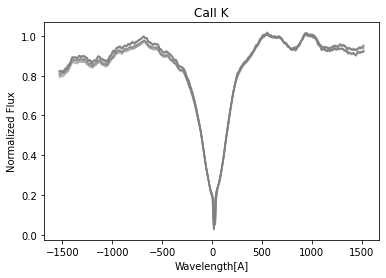

In [12]:
from astropy.io import fits as pyfits  # Module for reading and writing FITS files
import numpy as np  # Library for advanced numerical operations
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations

for i in range(a):
    # Construct the full path to the FITS file
    file_name=folder_path+'/'+resT[i]['dp_id']+'_TARGET_'+str(wave_range[0])+'-'+str(wave_range[1])+'.fits'

    # Check if the FITS file exists
    if os.path.exists(file_name): 
        hdulist = pyfits.open(file_name) # Open the FITS file
        scidata = hdulist[1].data # Bintable extension
        wave = scidata[0][0] # Wavelength data
        flux = scidata[0][1] # Flux data
        contw=[lammin,lammax]
        contf= flux[np.logical_and(wave > contw[0], wave < contw[1])] #Select fluxes within the wavelength range
        natwav=wave[np.logical_and(wave > contw[0], wave < contw[1])] # Select wavelengths within the range
        natf=contf/np.percentile(contf,95) # Normalize the flux
        flr = cg.downbin_spec(natf, natwav, wl, dlam=dwl) # Downsample the spectrum
        
        " Plot the normalized flux against wavelength "
        plt.plot(velocity,flr,c='grey',alpha=0.5)
        plt.xlabel('Wavelength[A]')
        plt.ylabel('Normalized Flux')
        plt.title('CaII K')
        
        # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
        if i==0:
            # If this is the first iteration (i == 0), create a new DataFrame df to store the flux data.
            df=pd.DataFrame(data=flr, columns=[resT[i]['dp_id']])
            # Create another DataFrame df2 to store the observation date (MJD) of the file.
            df2=pd.DataFrame(data=[[resT[i]['dp_id'],hdulist[0].header['MJD-OBS']]],columns=['dp_id','MJD'])
       
        
        else:
            # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
            df[resT[i]['dp_id']]=flr
            
            # Add the new observation date to the existing DataFrame df2.
            df2.loc[i]=[resT[i]['dp_id'],hdulist[0].header['MJD-OBS']]

    # Print a message if the file is not found
    else:
        print(f'File not found: {file_name}')

We save the processed data into CSV and Parquet files for future use. We then read these files back into DataFrames to ensure the data is correctly saved and can be reloaded. We also handle the velocity data separately.

In [13]:
df2.to_csv('ID-MJD.csv') # Save the df2 DataFrame to a CSV file
write('betaPicR-WST.parq', df) # Write the df DataFrame to a Parquet file
df2=pd.read_csv('ID-MJD.csv') # Read the 'ID-MJD.csv' file back into a DataFrame 

df=pd.read_parquet('betaPicR-WST.parq') # Read the parquet file back into a DataFrame 

dfvel=pd.read_csv('velocity.csv') # Read the 'velocity.csv' file into a DataFrame named dfvel
velocity=dfvel['Velocity'].values # Extract the 'Velocity' column from the dfvel DataFrame as an array

# Plot Spectra

We create a static plot of the normalized flux against velocity for all the spectra in our dataset. We overlay individual spectra in grey and plot the mean spectrum in red for better visualization. 

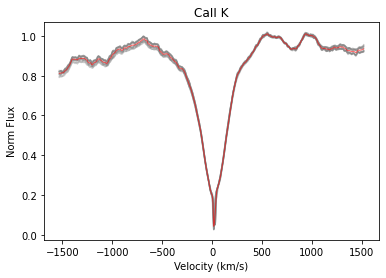

<Figure size 432x288 with 0 Axes>

In [14]:
from matplotlib.animation import FuncAnimation, PillowWriter  # Libraries for creating animations

# Loop through each spectrum in the DataFrame df2
for i in range(df2.shape[0]):
    # Plot the normalized flux against velocity for each individual spectrum in grey with some transparency
    plt.plot(velocity,df[df2['dp_id'][i]].values,c='grey',alpha=0.4)

# Plot the mean of all spectra in red with a slightly thicker line and reduced transparency to highlight it
plt.plot(velocity,df.mean(axis=1).values,lw=1,c='red',alpha=0.6)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Norm Flux')
plt.title('CaII K')
plt.show()
plt.savefig(folder_path+'/Static_'+target.replace(" ", "")+'.png', dpi=300,transparent=True)

 # Animation for Plotting Spectra

We create an animated GIF showing cumulative data plotted over time.

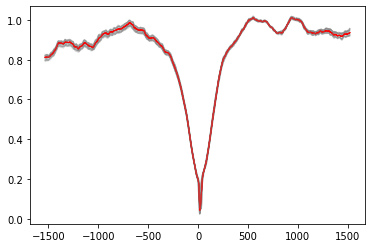

In [15]:
# Create a figure and axis for plotting
fig,ax = plt.subplots()
nframes=df.shape[1] # Determine the number of frames based on the number of columns in the DataFrame

'Cumulative Plot'

# Function to animate each frame
def animate(i):
    # Plot the mean values of the DataFrame as a red line
    line, = ax.plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.7)
    # Plot the values of the DataFrame for a specific dp_id as a grey line
    line2, = ax.plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.3)
    return line, line2#, line3, point1, point2, point3,
        
# Create the animation object
ani = FuncAnimation(fig, # The figure to animate
                    animate, # The function to call for each frame
                    interval=4, # Delay between frames in milliseconds
                    blit=True,  # Optimize by only redrawing parts that have changed
                    repeat=True, # Repeat the animation indefinitely
                    frames=range(nframes), # Number of frames in the animation
                    cache_frame_data=False)    
ani.save(folder_path+'/Faster_'+target.replace(" ", "")+'.gif', dpi=300, writer=PillowWriter(fps=20))

In [16]:
'Not Cumulative Plot'

# Function to animate each frame
def animate(i):
    ax.clear() # Clear the previous plot to avoid overlap of lines
    line, = ax.plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.7)
    line2, = ax.plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=1)
    return line, line2
        
ani = FuncAnimation(fig, animate, interval=4, blit=True, repeat=True, frames=range(nframes),cache_frame_data=False)    
ani.save(folder_path+'NonCum_'+target.replace(" ", "")+ ".gif", dpi=300, writer=PillowWriter(fps=20))

